In [94]:
# Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [96]:
DIRECTORY = r"C:\Users\Chamod Peiris\Documents\GitHub\Projects_24\Sys_MaskDetection\data"
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []

for category in CATEGORIES:
	path = os.path.join(DIRECTORY, category)
	for img in os.listdir(path):
		img_path = os.path.join(path, img)
		image = load_img(img_path, target_size=(224, 224))
		image = img_to_array(image)
		image = preprocess_input(image)

		data.append(image)
		labels.append(category)

In [97]:
#Encode and convert to numpy array
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(X_train, X_test, y_train, y_test) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)

In [99]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [101]:
INIT_LR = 1e-4

# MobileNetV2 model without the head
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# Head model on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="sigmoid")(headModel)

# Combine the base and head model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze head
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=INIT_LR),
	metrics=["accuracy"])

# summarize the model
print(model.summary())

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_11[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [102]:
EPOCHS = 20
BS = 32

# head model training
H = model.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, y_test),
	validation_steps=len(y_test) // BS,
	epochs=EPOCHS)

Epoch 1/20
177/177 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8955WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 59 batches). You may need to use the repeat() function when building your dataset.


177/177 [==============================] - 81s 443ms/step - loss: 0.3204 - accuracy: 0.8955 - val_loss: 0.0782 - val_accuracy: 0.9762
Epoch 2/20
177/177 [==============================] - 104s 590ms/step - loss: 0.0970 - accuracy: 0.9751
Epoch 3/20
177/177 [==============================] - 111s 625ms/step - loss: 0.0677 - accuracy: 0.9852
Epoch 4/20
177/177 [==============================] - 110s 623ms/step - loss: 0.0600 - accuracy: 0.9855
Epoch 5/20
177/177 [==============================] - 100s 564ms/step - loss: 0.0465 - accuracy: 0.9889
Epoch 6/20
177/177 [==============================] - 110s 620ms/step - loss: 0.0430 - accuracy: 0.9894
Epoch 7/20
177/177 [==============================] - 112s 634ms/step - loss: 0.0412 - accuracy: 0.9913
Epoch 8/20
177/177 [==============================] - 102s 572ms/step - loss: 0.0384 - accuracy: 0.9906
Epoch 9/20
177/177 [==============================] - 88s 500ms/step - loss: 0.0359 - accuracy: 0.9901
Epoch 10/20
177/177 [==============

In [103]:
predtest = model.predict(X_test, batch_size=BS)

# index of the label with the corresponding largest predicted probability
predtest = np.argmax(predtest, axis=1)

# classification report
print(classification_report(y_test.argmax(axis=1), predtest,
	target_names=lb.classes_))

60/60 [==============================] - 26s 422ms/step
              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       932
without_mask       1.00      0.98      0.99       957

    accuracy                           0.99      1889
   macro avg       0.99      0.99      0.99      1889
weighted avg       0.99      0.99      0.99      1889



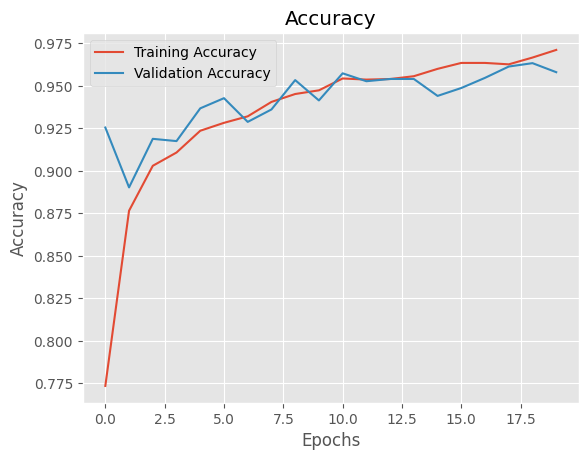

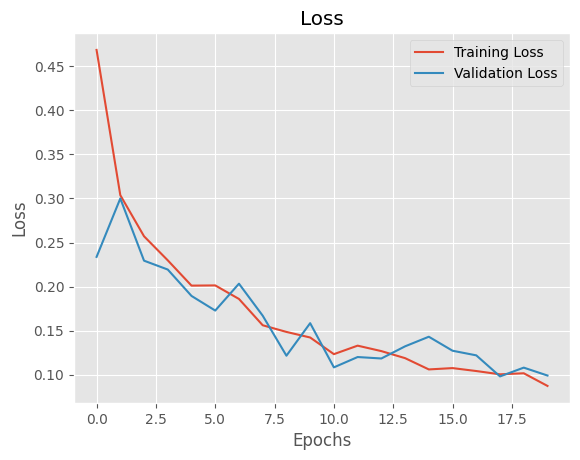

In [108]:
import matplotlib.pyplot as plt

# Get the accuracy and loss values from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [113]:
# save the model
filepath = r"C:\Users\Chamod Peiris\Documents\GitHub\Projects_24\Sys_MaskDetection\mask_detector.model"
model.save(filepath, save_format="h5")

c:\Users\Chamod Peiris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
